# Scrabbledice
This is a project that I worked on with the owner of Twin City Games. The board game he is designing involves rolling dice with letters rather than numbers on their faces, and then making words with the rolled letters. The objective of this project is to figure out how to choose and arrange the letters on the dice so that players will always be able to make words, regardless of what they roll.

## Project summary

The "best" arrangement of letters on the dice is a pretty nebulous goal, so we narrowed the objective down a bit. Say you roll a particular set of dice, say , resulting in six letters. There is a finite number of words that can be made from those letters. If you calculate the maximum number of words that can be made for every possible roll of the same set of dice and sum those numbers, then that can give an approximate measurement for the "goodness" of a set of dice. If you rearrange the letters on the dice and calculate the "goodness" again, then you have an objective way to compare the two arrangements of letters. Armed with an objective (if imperfect) measurement for the "goodness" of a set of dice, we can do some fun machine learning to optimize our dice with respect to their "goodness". 

Our first step to solving the problem was to choose a set of letters that would be arranged on six dice. Starting with the relative frequency of letters in the English language (available on [Wikipedia](https://en.wikipedia.org/wiki/Letter_frequency)), we normalized the letter frequencies so that they added up to 36. Then we rounded the resulting frequencies (sometimes up, sometimes down, there's a little subjectivity and wiggle room here) to give us a nice even 36 letters to arrange on the dice: 'aaabcddeeeefghhiillmnnoooprrsstttuwy'.

So now that we'd settled on a definite set of letters, we needed to optimize their arrangement on the dice. To do that, I employed the following simple version of a genetic algorithm:
 - Calculate the "goodness" of a particular arrangement of letters
 - Mutate the dice (switch two letters on different dice)
 - Calculate the "goodness" of the new letter arrangement
 - After X iterations, return to the best letter arrangement so far
This simple structure uses a nice random walk to create a "generation" of new letter arrangements, but at the beginning of each generation, the algorithm starts back at the best arrangement it's found so far. Getting a bit more technical, the number of arrangements in each generation X should be tuned so that we allow the algorithm to explore enough of the configuration space so that it doesn't get stuck in a local maximum, but we still want the algorithm to focus on working with the best letter arrangements.

## The code

In [1]:
import twl
import random
import operator
import json
import os

In order to determine the number of words that can be made with a particular set of letters, I'm using the twl package, which will pretty efficiently compare a set of letters against a scrabble dictionary.

In [2]:
def sort_dice(dice):
    """
    Rearrange dice alphabetically so that sets of dice can't be duplicated
    """
    
    # First, sort letters on each die
    for i in range(6):
        dice[i] = sorted(dice[i])
        
    # Make one string for each die, then sort the resulting strings
    d6s = ["".join(dice[i]) for i in range(6)]
    d6s = sorted(d6s)
    # Return letters to format of six lists of six letters each
    sorted_dice = [ list(string) for string in d6s ]
    
    return sorted_dice

In [3]:
def mutate(dice):
    """
    Switch two different letters on two different dice
    """
    
    # Generate random numbers to determine which letters to swap
    randints = [random.randint(0,5) for i in range(4)]
    # Ensure letters to swap are on different dice
    while (randints[0] == randints[2]):
        randints = [random.randint(0,5) for x in range(4)]
        
    # Switch letters on dice
    l1 = dice[randints[0]][randints[1]]
    l2 = dice[randints[2]][randints[3]]
    dice[randints[0]][randints[1]] = l2
    dice[randints[2]][randints[3]] = l1
    
    # Rearrange dice to get unique id for each arrangement of letters
    dice = sort_dice(dice)
    
    return dice

In [4]:
def wordcount(somedice):
    """
    Given an arrangement of letters on six dice,
    count the total number of words that can be made with unique dice rolls
    """
    wordcount = 0
    explored_rolls = {}
    words3l = 0
    words4l = 0
    words5l = 0
    words6l = 0
    
    # Iterate through all possible rolls
    for i in range(6):
        for j in range(6):
            for k in range(6):
                for l in range(6):
                    for m in range(6):
                        for n in range(6):
                            rolled_letters = [
                                somedice[dice][letter] for dice, letter 
                                in enumerate([i,j,k,l,m,n])
                            ]
                            rolled_letters = "".join(sorted(rolled_letters))
                            words_by_len = [0 for x in range(6)]
                            
                            # Get a list of all possible words
                            poss_words = list(twl.anagram(rolled_letters))
                            # Count possible 3,4,5,6 letter words
                            for w in poss_words:
                                if len(w) == 3:
                                    words3l += 1
                                elif len(w) == 4:
                                    words4l += 1
                                elif len(w) == 5:
                                    words5l += 1
                                elif len(w) == 6:
                                    words6l += 1
                                    
                            # Keep track of wordcount for unique roll results
                            if not rolled_letters in explored_rolls:
                                wc = len(poss_words)
                                explored_rolls[rolled_letters] = wc
                                wordcount += wc
                                
    # Average the wordcounts
    results = {}
    results['total_words'] = wordcount
    for i, wc in enumerate([words3l, words4l, words5l, words6l]):
        s = str(i+3)+"_letter_words"
        results[s] = wc / 6**6
    
    return results

In [5]:
def read_results(results_file):
    
    # Check for previous results in a file
    if os.path.isfile(results_file):
        with open(results_file, 'r') as f:
            possible_dice = json.load(f)
            
        # Get best set of dice so far
        scores = {k:possible_dice[k]['total_words'] 
                  for k in possible_dice.keys()}
        best_dice = sorted(scores.items(), key=lambda kv: kv[1])[-1][0]

        print("best arrangement so far:",best_dice)
        # Convert single string to lists of letters
        best_dice = [ [best_dice[j*6+i] for i in range(6)] for j in range(6) ]

            
    else:  # Set up the original dice
        best_dice = [['a','a','a','b','c','d'],
                     ['d','e','e','e','e','f'],
                     ['g','h','h','i','i','l'],
                     ['l','m','n','n','o','o'],
                     ['o','p','r','r','s','s'],
                     ['t','t','t','u','w','y']]
        possible_dice = {}
        
    
    return best_dice, possible_dice

## Main loop

In [6]:
# Modifiable parameters
generations = 3
generation_size = 25
results_file = "test_possibilities.json"

In [7]:
# Run for X generations
g = 0
while g < generations:
    
    # Look up what dice have been explored so far, picking out the best
    best_dice, explored_arrangements = read_results(results_file)
    dice = best_dice
    
    # Try some random mutations
    c = 0
    while c < generation_size:
        
        dice = mutate(dice)
        diceset = "".join(["".join(letters) for letters in dice])
        print(diceset)
        
        # If this letter arrangement is not already explored, evaluate it
        if diceset not in explored_arrangements:
            explored_arrangements[diceset] = wordcount(dice)
            print(" ^ scores",explored_arrangements[diceset]['total_words'])
            c += 1
            
    # Write updated results to file
    with open(results_file, 'w') as f:
        json.dump(explored_arrangements, f)
        
    g += 1
    print("\nCompleted generation",g,"of mutations\n")

best arrangement so far: abelopacdeftaghostdelmnrehirswinotuy
abelotacdeftaghostdelmnrehirswinopuy
 ^ scores 907528
abelotacdeftaghostdelmnreiirswhnopuy
 ^ scores 793098
abelotacdfptaghostdelmnrehnouyeiirsw
 ^ scores 824672
abelotacdfptaghstudelmnrehnooyeiirsw
 ^ scores 739153
abelotacdfptaghstudelmnreehnoyiiorsw
 ^ scores 744510
abelotacdfptaghsstdelmnreehnoyiioruw
 ^ scores 628162
abeloyacdfptaghsstdelmnreehnotiioruw
 ^ scores 639804
abeloracdfptaghsstdelmnreehnotiiouwy
 ^ scores 602458
abeloracdfptaghsstdemnrweehnotiilouy
 ^ scores 628243
abloryacdfptaghsstdemnrweehnoteiilou
 ^ scores 657727
acdfptaghsstalorwybdemnreehnoteiilou
 ^ scores 661010
acdfptaeenotalorwybdemnreiiloughhsst
 ^ scores 550904
acfnptadeeotalorwybdemnreiiloughhsst
 ^ scores 548380
acdfptadeeotalorwybemnnreiiloughhsst
 ^ scores 469958
acdfptadeeeoalorwybmnnrteiiloughhsst
 ^ scores 409957
acdfptaeeeloalorwybmnnrtdeiioughhsst
 ^ scores 399346
abeeloacdfptalorwydeiiouemnnrtghhsst
 ^ scores 486913
abeeloacfprtalorwyde

# View results

It's not obvious that the goodness score we're using will result in the best letter arrangement. In addition to scoring the arrangements on that count, I've also kept track of how many 3, 4, 5, and 6-letter words can be made from each arrangement, which is stored in the .json file that contains the results. Once the algorithm has explored a bunch of different letter arrangements, we can look at some of the "best" letter arrangements and see what you could expect to be able to do with an average roll.

In [8]:
import pandas as pd
import numpy as np

In [9]:
results_df = pd.read_json(results_file, orient='index')
results_df.head(5)

,3_letter_words,4_letter_words,5_letter_words,6_letter_words,total_words
aaabcddeeeefghhiillnnooumtttwyoprrss,18.372428,14.046639,4.003472,0.439150,87014
aaabcddeeeefghiilnhlnooumtttwyoprrss,17.951003,13.552748,3.823131,0.405478,115887
aaabcddprrsseeeefoghiilnhlnooumtttwy,18.397762,14.140454,4.010652,0.455783,126089
aabcdhagiilndprrsseeeefohlnooumtttwy,17.636831,13.359739,3.812607,0.437371,178448
aabcdhagiilndlprsseeeefohnoorumtttwy,17.205247,13.122964,3.824653,0.457433,221352


In [10]:
# Sort the results by our total_words metric
results_df.sort_values(by=['total_words'],
                       ascending=False,
                       inplace=True)
results_df.head(10)

,3_letter_words,4_letter_words,5_letter_words,6_letter_words,total_words
abelopacdeftaghostdelmnrehirswinotuy,14.162959,9.845679,2.602152,0.284894,983670
abelopacdeftahostudelmnrehirswginoty,14.117584,9.802533,2.576239,0.277799,979747
abilopacdeftahostudelmnregnotyehirsw,14.010631,9.781250,2.590063,0.280564,979491
abdiloadefptagostucelmnrehirswehnoty,13.938979,9.825939,2.607360,0.285944,976785
ablnopacdeftahostudelmnregiotyehirsw,14.165488,9.928927,2.640389,0.290638,972828
abeiopacdfltahostudelmnregnotyehirsw,14.127293,9.984053,2.661008,0.292974,972536
abenopacdefiahostudelmnrehrstwgiloty,14.166967,9.783565,2.578254,0.281722,970400
acdeftahoptuailoswbehirsdelmnregnoty,13.904771,9.851402,2.615055,0.283822,969939
abilosacdeftahoptudelmnregnotyehirsw,13.891525,9.819895,2.590364,0.281400,968804
abdiloadefptahostucelmnregnotyehirsw,13.950467,9.845250,2.593471,0.282536,968461


These results show the average number of words of a particular length that can be made, as well as the total number of words that can be made from unique rolls.

One thing that jumps out to me is that in the beginning of the simulation, as we see a lot of repitition of letters on dice, it looks like the number of possible words per roll is higher than when letters are more spread out.   So near the purely alphabetical arrangement, you could expect to be able to make 13 or 14 4-letter words, whereas that drops to 9 or 10 when letters are more evenly distributed.

This makes some sense if we think about it: in the original arrangement, there are three a's on one dice, four e's on another, giving you a 50% chance to roll exactly one a, a 67% chance to roll exactly one e, and a 33% chance of rolling both of the two most common vowels.

On the other hand, if the three a's are spread out on three different dice, there's a 1-(5/6)^3, or 42% chance of rolling at least one a, and the chances of rolling at least one e when they are spread out one per die drop to 52%. So if common letters are spread out among the dice, they are actually less likely to be rolled. If the dice are less likely to yield the most common letters, then it makes sense that on average, the number of words that can be made will decrease.

Clustering individual vowels on the same dice may make it more likely to roll common letters, but it also limits the realm of possible words that can be made. If all of the e's are one one dice, it's likely that e will be rolled, but it's impossible for two e's to be rolled, and I think demonstrates why we have to be careful what variable we're trying to maximize. I think the game would be less fun if you're always making the same words from your dice.

That brings us to the arrangements that score well on the total word count. Based on a casual observation, it doesn't look like there's a big difference between arrangements in terms of possible 3, 4, 5, and 6-letter words.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

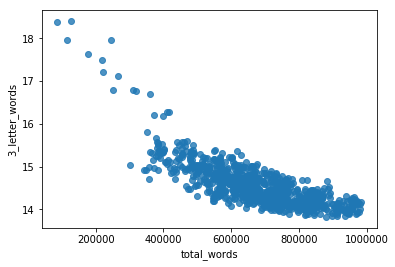

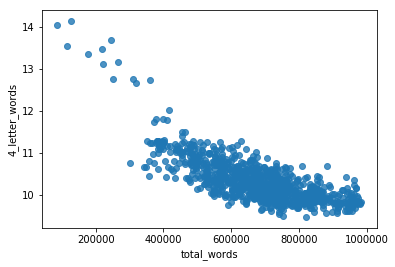

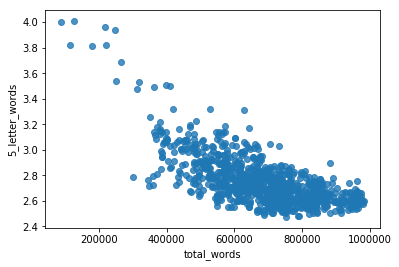

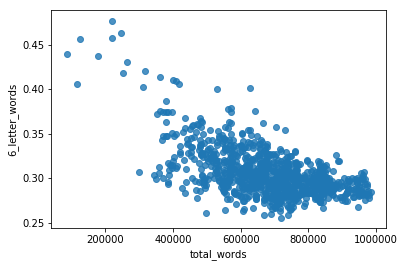

In [12]:
for col in ['3_letter_words', '4_letter_words', 
            '5_letter_words', '6_letter_words']:
    ax = sns.regplot('total_words', col, 
                     results_df, fit_reg=False)
    plt.show()

Looking at the total_words score plotted against the average number of 3, 4, 5, and 6-letter words per roll gives a fairly consistent distribution, albeit with the leftward tail of outliers likely showing a pretty strong bias towards being very similar to our initial arrangement. 

However, one noticeable trend is what looks like greater variance (as a percentage of the expected words per roll) for longer words.

# Conclusions

At this point, I've satisfied myself that the algorithm I've designed is indeed working towards optimizing what I defined as a fitness function for an arrangement of letters on a set of dice. I am also satisfied that optimizing this particular fitness function doesn't totally kill the number of words that a player can expect to be able to make.

As it's written, the algorithm will run for some number of generations. If I were being scientific, I would include some convergence criterion that would stop the algorithm once it fails to find a better arrangement in X generations, but my purpose in this case is to provide a couple of options that will have to be playtested, and I can simply run the algorithm for as long as I like.